In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,6
import pyaf.ForecastEngine as autof
import pyaf
import pyaf.HierarchicalForecastEngine as hfe
import pyaf.TS
import pyaf.Bench

In [428]:
test=pd.read_csv('test_data.csv')
train=pd.read_csv('train_data.csv')

In [429]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [403]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [404]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [405]:
train.shape

(913000, 4)

dateparse= lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
train=pd.read_csv('train_data.csv',parse_dates=['date'],index_col='date',date_parser=dateparse)

In [406]:
#for pyaf dont use index
dateparse= lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
train=pd.read_csv('train_data.csv',parse_dates=['date'],date_parser=dateparse)

In [407]:
print(set(train.store),'\n',set(train.item))
n_store=set(train.store)
n_item=set(train.item)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10} 
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}


In [ ]:
if you want top learn only one time series then run this snippet
def store_item_combination1(ts,store,item):
    ts=ts[(ts['store']==store) &(ts['item']==item)]
    del ts['store']
    del ts['item']
    training_length=ts.shape[0]*.8
    return ts,int(training_length)
ts1,training_length=store_item_combination1(train,1,1)

In [408]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [409]:
train[(train['store']==3) &(train['item']==1)].sales.head()

3652    19
3653     8
3654    10
3655    15
3656    22
Name: sales, dtype: int64

In [512]:
def store_item_combination(ts,store,item):
    selected_sales=ts[(ts['store']==store)&(ts['item']==item)].sales
    return selected_sales

In [513]:
X=pd.DataFrame()


In [514]:
X=pd.DataFrame()
for item in set(train.item):
    for store in set(train.store):
        X[str(item)+'_'+str(store)]=np.array(store_item_combination(train,store,item))

In [515]:
X['date']=train['date']

In [516]:
X=X[['date']+list(X.columns[:-1])]

In [517]:
X.head()

,date,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,...,50_1,50_2,50_3,50_4,50_5,50_6,50_7,50_8,50_9,50_10
0,2013-01-01,13,12,19,10,11,20,7,16,11,...,30,43,45,38,19,20,21,45,36,33
1,2013-01-02,11,16,8,12,9,6,4,10,9,...,32,57,47,35,25,23,30,54,44,37
2,2013-01-03,14,16,10,8,12,11,8,12,20,...,25,45,39,32,28,38,20,54,29,46
3,2013-01-04,13,20,15,15,8,7,7,21,22,...,32,45,48,36,27,33,27,52,43,51
4,2013-01-05,10,16,22,19,13,12,8,15,22,...,35,55,46,47,31,33,18,48,53,41


In [519]:
X.shape

(1826, 501)

In [520]:
no_of_items_per_store=5
col_req=(no_of_items_per_store*10)+1
X=X[X.columns[:col_req]]

In [521]:
X.head()

,date,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,...,5_1,5_2,5_3,5_4,5_5,5_6,5_7,5_8,5_9,5_10
0,2013-01-01,13,12,19,10,11,20,7,16,11,...,11,4,13,10,9,4,5,10,9,8
1,2013-01-02,11,16,8,12,9,6,4,10,9,...,6,6,9,5,5,9,8,9,11,13
2,2013-01-03,14,16,10,8,12,11,8,12,20,...,8,12,10,12,3,10,9,14,8,10
3,2013-01-04,13,20,15,15,8,7,7,21,22,...,9,16,20,7,12,5,4,10,15,10
4,2013-01-05,10,16,22,19,13,12,8,15,22,...,8,9,13,5,8,8,9,14,13,13


In [604]:
rows_list = [];
def lHierarchy_dict(stores,items):
    #1 preparing datafram to pass in data parameter of dictionary
    for item in items:
        for store in stores:
            item_name=str(item)+'_'+str(store)
            rows_list.append([item_name,str(store),'All_store_combinations'])
    lLevels=['item','store','All_store_combinations']
    lHierarchy={}
    lHierarchy['Levels'] = lLevels;
    lHierarchy['Data'] = pd.DataFrame(rows_list, columns =  lLevels);
    lHierarchy['Type'] = "Hierarchical";
    
    return lHierarchy

In [605]:
stores=np.arange(1,11)
items=np.arange(1,6)
lHierarchy={}
lHierarchy=lHierarchy_dict(stores,items)


In [606]:
lHierarchy

{'Levels': ['item', 'store', 'All_store_combinations'],
 'Data':     item store  All_store_combinations
 0    1_1     1  All_store_combinations
 1    1_2     2  All_store_combinations
 2    1_3     3  All_store_combinations
 3    1_4     4  All_store_combinations
 4    1_5     5  All_store_combinations
 5    1_6     6  All_store_combinations
 6    1_7     7  All_store_combinations
 7    1_8     8  All_store_combinations
 8    1_9     9  All_store_combinations
 9   1_10    10  All_store_combinations
 10   2_1     1  All_store_combinations
 11   2_2     2  All_store_combinations
 12   2_3     3  All_store_combinations
 13   2_4     4  All_store_combinations
 14   2_5     5  All_store_combinations
 15   2_6     6  All_store_combinations
 16   2_7     7  All_store_combinations
 17   2_8     8  All_store_combinations
 18   2_9     9  All_store_combinations
 19  2_10    10  All_store_combinations
 20   3_1     1  All_store_combinations
 21   3_2     2  All_store_combinations
 22   3_3     3 

In [607]:
items,stores

(array([1, 2, 3, 4, 5]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [608]:
lHierarchy['Levels']

['item', 'store', 'All_store_combinations']

In [609]:
lHierarchy['Data'].tail(12)

,item,store,All_store_combinations
38,4_9,9,All_store_combinations
39,4_10,10,All_store_combinations
40,5_1,1,All_store_combinations
41,5_2,2,All_store_combinations
42,5_3,3,All_store_combinations
43,5_4,4,All_store_combinations
44,5_5,5,All_store_combinations
45,5_6,6,All_store_combinations
46,5_7,7,All_store_combinations
47,5_8,8,All_store_combinations


In [610]:
lHierarchy['Data'].head(10)

,item,store,All_store_combinations
0,1_1,1,All_store_combinations
1,1_2,2,All_store_combinations
2,1_3,3,All_store_combinations
3,1_4,4,All_store_combinations
4,1_5,5,All_store_combinations
5,1_6,6,All_store_combinations
6,1_7,7,All_store_combinations
7,1_8,8,All_store_combinations
8,1_9,9,All_store_combinations
9,1_10,10,All_store_combinations


In [611]:
lHierarchy['Data'].shape

(50, 3)

In [612]:
import pyaf.HierarchicalForecastEngine as hautof
from IPython.display import display


In [613]:
X.head()

,date,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,...,5_1,5_2,5_3,5_4,5_5,5_6,5_7,5_8,5_9,5_10
0,2013-01-01,13,12,19,10,11,20,7,16,11,...,11,4,13,10,9,4,5,10,9,8
1,2013-01-02,11,16,8,12,9,6,4,10,9,...,6,6,9,5,5,9,8,9,11,13
2,2013-01-03,14,16,10,8,12,11,8,12,20,...,8,12,10,12,3,10,9,14,8,10
3,2013-01-04,13,20,15,15,8,7,7,21,22,...,9,16,20,7,12,5,4,10,15,10
4,2013-01-05,10,16,22,19,13,12,8,15,22,...,8,9,13,5,8,8,9,14,13,13


In [614]:
X.date=pd.to_datetime(X.date, format="%Y-%m-%d")

INFO:pyaf.std:START_HIERARCHICAL_PLOTTING


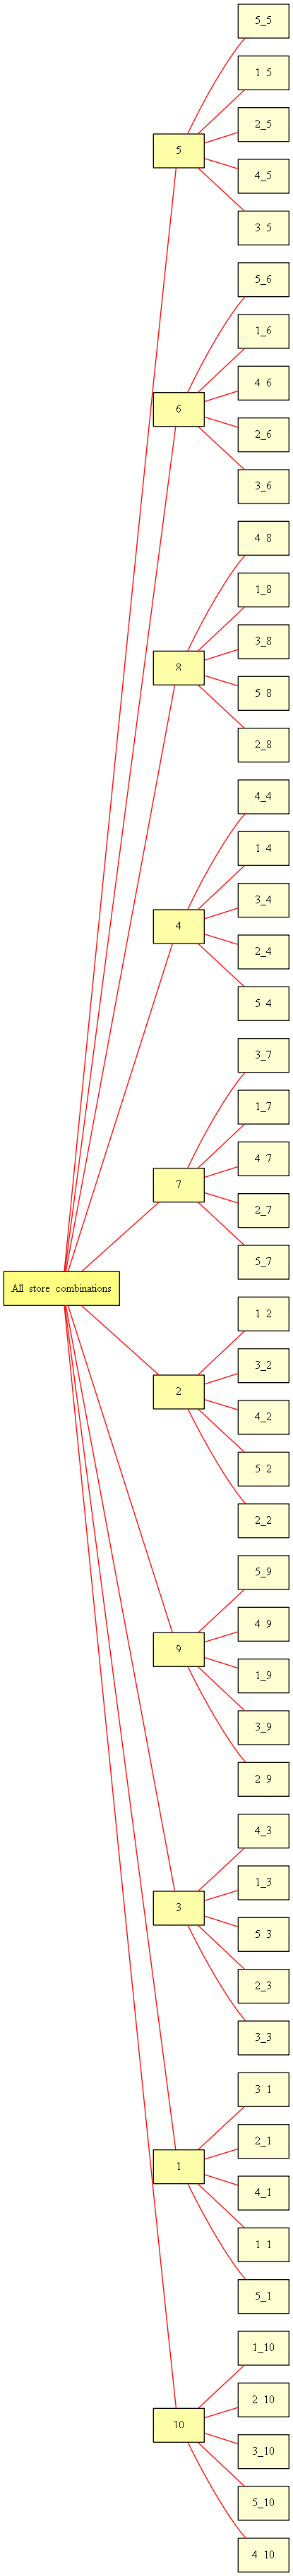

INFO:pyaf.std:END_HIERARCHICAL_PLOTTING_TIME_IN_SECONDS 0.9880876541137695


In [615]:
lEngine = hautof.cHierarchicalForecastEngine()
lSignalHierarchy = lEngine.plot_Hierarchy(iInputDS=X , iTime="date", iSignal="sales", iHorizon=1,iHierarchy=lHierarchy,iExogenousData= None)

In [617]:
lSignalHierarchy.mStructure

{0: {'1_1': set(),
  '1_2': set(),
  '1_3': set(),
  '1_4': set(),
  '1_5': set(),
  '1_6': set(),
  '1_7': set(),
  '1_8': set(),
  '1_9': set(),
  '1_10': set(),
  '2_1': set(),
  '2_2': set(),
  '2_3': set(),
  '2_4': set(),
  '2_5': set(),
  '2_6': set(),
  '2_7': set(),
  '2_8': set(),
  '2_9': set(),
  '2_10': set(),
  '3_1': set(),
  '3_2': set(),
  '3_3': set(),
  '3_4': set(),
  '3_5': set(),
  '3_6': set(),
  '3_7': set(),
  '3_8': set(),
  '3_9': set(),
  '3_10': set(),
  '4_1': set(),
  '4_2': set(),
  '4_3': set(),
  '4_4': set(),
  '4_5': set(),
  '4_6': set(),
  '4_7': set(),
  '4_8': set(),
  '4_9': set(),
  '4_10': set(),
  '5_1': set(),
  '5_2': set(),
  '5_3': set(),
  '5_4': set(),
  '5_5': set(),
  '5_6': set(),
  '5_7': set(),
  '5_8': set(),
  '5_9': set(),
  '5_10': set()},
 1: {'1': {'1_1', '2_1', '3_1', '4_1', '5_1'},
  '2': {'1_2', '2_2', '3_2', '4_2', '5_2'},
  '3': {'1_3', '2_3', '3_3', '4_3', '5_3'},
  '4': {'1_4', '2_4', '3_4', '4_4', '5_4'},
  '5': {'1_5

In [618]:
import pyaf.HierarchicalForecastEngine as hautof

lEngine = hautof.cHierarchicalForecastEngine()

lSignalVar = "Sales";
lSignalHierarchy = lEngine.train(X , 'date', lSignalVar, 1, lHierarchy, None);

INFO:pyaf.std:START_HIERARCHICAL_TRAINING
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 1_1
INFO:pyaf.std:START_TRAINING '1_1'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '1_1' 10.942942142486572
INFO:pyaf.std:TIME_DETAIL TimeVariable='date' TimeMin=2013-01-01T00:00:00.000000 TimeMax=2016-12-30T00:00:00.000000 TimeDelta=<DateOffset: days=1> Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='1_1' Min=4 Max=50  Mean=19.971522453450163 StdDev=6.7391761080508115
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_1_1' Min=4 Max=50  Mean=19.971522453450163 StdDev=6.7391761080508115
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_1_1_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_1_1_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_1_1_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_1_1_ConstantTrend_residue_zeroCycle_residue_AR(64)' 

INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_1_3_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_1_3_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_1_3_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_1_3_ConstantTrend_residue_zeroCycle_residue_AR(64)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1998 MAPE_Forecast=0.1722 MAPE_Test=0.1697
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.1823 SMAPE_Forecast=0.1661 SMAPE_Test=0.1564
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.6616 MASE_Forecast=0.6843 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=4.18000439163273 L1_Forecast=4.709148993840257 L1_Test=3.2244734806328808
INFO:pyaf.std:MODEL_L2 L2_Fit=5.28675707359621 L2_Forecast=5.901437838099209 L2_Test=3.2244734806328808
INFO:pyaf.std:MODEL_COMPLEXITY 64
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _1_3_ConstantTrend_residue_zeroCycle_residue_Lag28 0.16402169

INFO:pyaf.std:MODEL_L1 L1_Fit=3.478838324075232 L1_Forecast=3.352788056587231 L1_Test=3.9145295127296738
INFO:pyaf.std:MODEL_L2 L2_Fit=4.337712003229635 L2_Forecast=4.219834126319559 L2_Test=3.9145295127296738
INFO:pyaf.std:MODEL_COMPLEXITY 64
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _1_6_ConstantTrend_residue_zeroCycle_residue_Lag21 0.12537975608283505
INFO:pyaf.std:AR_MODEL_COEFF 2 _1_6_ConstantTrend_residue_zeroCycle_residue_Lag7 0.12298242691808735
INFO:pyaf.std:AR_MODEL_COEFF 3 _1_6_ConstantTrend_residue_zeroCycle_residue_Lag1 0.09655842643054902
INFO:pyaf.std:AR_MODEL_COEFF 4 _1_6_ConstantTrend_residue_zeroCycle_residue_Lag3 0.09087004226338044
INFO:pyaf.std:AR_MODEL_COEFF 5 _1_6_ConstantTrend_residue_zeroCycle_residue_Lag14 0.08826042024799766
INFO:pyaf.std:AR_MODEL_COEFF 6 _1_6_ConstantTrend_residue_zeroCycle_residue_Lag28 0.07717803894335865
INFO:pyaf.std:AR_MODEL_COEFF 7 _1_6_ConstantTrend_residue_zeroCycle_residue_Lag2 0.07687342608309747
INFO:pyaf.

INFO:pyaf.std:AR_MODEL_COEFF 3 _1_9_ConstantTrend_residue_zeroCycle_residue_Lag5 0.09666642125977637
INFO:pyaf.std:AR_MODEL_COEFF 4 _1_9_ConstantTrend_residue_zeroCycle_residue_Lag42 0.09524086235780405
INFO:pyaf.std:AR_MODEL_COEFF 5 _1_9_ConstantTrend_residue_zeroCycle_residue_Lag28 0.0896658728231704
INFO:pyaf.std:AR_MODEL_COEFF 6 _1_9_ConstantTrend_residue_zeroCycle_residue_Lag2 0.08815159157470248
INFO:pyaf.std:AR_MODEL_COEFF 7 _1_9_ConstantTrend_residue_zeroCycle_residue_Lag63 0.08754441599070238
INFO:pyaf.std:AR_MODEL_COEFF 8 _1_9_ConstantTrend_residue_zeroCycle_residue_Lag4 0.08597424451570537
INFO:pyaf.std:AR_MODEL_COEFF 9 _1_9_ConstantTrend_residue_zeroCycle_residue_Lag43 -0.08312167770022745
INFO:pyaf.std:AR_MODEL_COEFF 10 _1_9_ConstantTrend_residue_zeroCycle_residue_Lag14 0.08309482444116875
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 2_1
INFO:pyaf.std:START_TRAINING '2_1'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '2_1' 11.66195845

INFO:pyaf.std:AR_MODEL_COEFF 9 _2_2_ConstantTrend_residue_zeroCycle_residue_Lag4 0.09662622957911467
INFO:pyaf.std:AR_MODEL_COEFF 10 _2_2_ConstantTrend_residue_zeroCycle_residue_Lag6 0.0891683429101577
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 2_3
INFO:pyaf.std:START_TRAINING '2_3'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '2_3' 12.167081117630005
INFO:pyaf.std:TIME_DETAIL TimeVariable='date' TimeMin=2013-01-01T00:00:00.000000 TimeMax=2016-12-30T00:00:00.000000 TimeDelta=<DateOffset: days=1> Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='2_3' Min=19 Max=131  Mean=66.80449069003286 StdDev=18.472400346904294
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_2_3' Min=19 Max=131  Mean=66.80449069003286 StdDev=18.472400346904294
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_2_3_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL 

INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_2_6' Min=14 Max=91  Mean=44.53395399780942 StdDev=12.498551829630985
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_2_6_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_2_6_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_2_6_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_2_6_ConstantTrend_residue_zeroCycle_residue_AR(64)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1423 MAPE_Forecast=0.14 MAPE_Test=0.1546
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.136 SMAPE_Forecast=0.1361 SMAPE_Test=0.1675
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.6022 MASE_Forecast=0.6374 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=5.582860825608355 L1_Forecast=6.648846457921189 L1_Test=7.883798313516891
INFO:pyaf.std:MODEL_L2 L2_Fit=7.029970860224779 L2_Forecast=8.273101057677456 L2_Test=7.883798313516891
INFO:pyaf.std:MODEL_COMPLEXI

INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.1232 SMAPE_Forecast=0.1165 SMAPE_Test=0.0096
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.613 MASE_Forecast=0.5771 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=7.119017820649735 L1_Forecast=7.7998317912699076 L1_Test=0.607015900093991
INFO:pyaf.std:MODEL_L2 L2_Fit=8.896948872799962 L2_Forecast=10.022363617865867 L2_Test=0.607015900093991
INFO:pyaf.std:MODEL_COMPLEXITY 64
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _2_9_ConstantTrend_residue_zeroCycle_residue_Lag1 0.17494476985113297
INFO:pyaf.std:AR_MODEL_COEFF 2 _2_9_ConstantTrend_residue_zeroCycle_residue_Lag7 0.16696549649467124
INFO:pyaf.std:AR_MODEL_COEFF 3 _2_9_ConstantTrend_residue_zeroCycle_residue_Lag2 0.15623069547088872
INFO:pyaf.std:AR_MODEL_COEFF 4 _2_9_ConstantTrend_residue_zeroCycle_residue_Lag14 0.12047373828598387
INFO:pyaf.std:AR_MODEL_COEFF 5 _2_9_ConstantTrend_residue_zeroCycle_residue_Lag35 0.11886752390719738
INFO:pyaf.std:AR_MODEL_COEFF 6 _2_9_ConstantTrend_resi

INFO:pyaf.std:AR_MODEL_COEFF 3 _3_2_ConstantTrend_residue_zeroCycle_residue_Lag35 0.1408707901450418
INFO:pyaf.std:AR_MODEL_COEFF 4 _3_2_ConstantTrend_residue_zeroCycle_residue_Lag14 0.12123479281235629
INFO:pyaf.std:AR_MODEL_COEFF 5 _3_2_ConstantTrend_residue_zeroCycle_residue_Lag28 0.11731789066330905
INFO:pyaf.std:AR_MODEL_COEFF 6 _3_2_ConstantTrend_residue_zeroCycle_residue_Lag2 0.11024975447919827
INFO:pyaf.std:AR_MODEL_COEFF 7 _3_2_ConstantTrend_residue_zeroCycle_residue_Lag6 0.09249967046164571
INFO:pyaf.std:AR_MODEL_COEFF 8 _3_2_ConstantTrend_residue_zeroCycle_residue_Lag42 0.08601502143196224
INFO:pyaf.std:AR_MODEL_COEFF 9 _3_2_ConstantTrend_residue_zeroCycle_residue_Lag56 0.08066852054698634
INFO:pyaf.std:AR_MODEL_COEFF 10 _3_2_ConstantTrend_residue_zeroCycle_residue_Lag48 -0.07932356952011742
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 3_3
INFO:pyaf.std:START_TRAINING '3_3'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '3_3' 11.0169172

INFO:pyaf.std:AR_MODEL_COEFF 10 _3_5_ConstantTrend_residue_zeroCycle_residue_Lag63 0.0652910738674738
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 3_6
INFO:pyaf.std:START_TRAINING '3_6'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '3_6' 11.607221603393555
INFO:pyaf.std:TIME_DETAIL TimeVariable='date' TimeMin=2013-01-01T00:00:00.000000 TimeMax=2016-12-30T00:00:00.000000 TimeDelta=<DateOffset: days=1> Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='3_6' Min=8 Max=61  Mean=27.81106243154436 StdDev=8.460455547526822
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_3_6' Min=8 Max=61  Mean=27.81106243154436 StdDev=8.460455547526822
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_3_6_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_3_6_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_3_6_ConstantTrend_residue_zeroCycle' [No

INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_3_9_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_3_9_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_3_9_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_3_9_ConstantTrend_residue_zeroCycle_residue_AR(64)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1606 MAPE_Forecast=0.1418 MAPE_Test=0.0247
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.153 SMAPE_Forecast=0.1378 SMAPE_Test=0.025
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.6315 MASE_Forecast=0.6197 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=5.544483660989349 L1_Forecast=5.7254074792787 L1_Test=0.9878777140623072
INFO:pyaf.std:MODEL_L2 L2_Fit=7.041198104186941 L2_Forecast=7.231829963314438 L2_Test=0.9878777140623072
INFO:pyaf.std:MODEL_COMPLEXITY 64
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _3_9_ConstantTrend_residue_zeroCycle_residue_Lag7 0.16811952335

INFO:pyaf.std:MODEL_L1 L1_Fit=4.4002455425215246 L1_Forecast=4.700898386806072 L1_Test=1.2208674721397585
INFO:pyaf.std:MODEL_L2 L2_Fit=5.59142874610535 L2_Forecast=6.089402576095619 L2_Test=1.2208674721397585
INFO:pyaf.std:MODEL_COMPLEXITY 64
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _4_2_ConstantTrend_residue_zeroCycle_residue_Lag7 0.13447765743771692
INFO:pyaf.std:AR_MODEL_COEFF 2 _4_2_ConstantTrend_residue_zeroCycle_residue_Lag1 0.13343237815991385
INFO:pyaf.std:AR_MODEL_COEFF 3 _4_2_ConstantTrend_residue_zeroCycle_residue_Lag14 0.1171933703276028
INFO:pyaf.std:AR_MODEL_COEFF 4 _4_2_ConstantTrend_residue_zeroCycle_residue_Lag35 0.10966672402553551
INFO:pyaf.std:AR_MODEL_COEFF 5 _4_2_ConstantTrend_residue_zeroCycle_residue_Lag28 0.10290119080760747
INFO:pyaf.std:AR_MODEL_COEFF 6 _4_2_ConstantTrend_residue_zeroCycle_residue_Lag63 0.08769617423176979
INFO:pyaf.std:AR_MODEL_COEFF 7 _4_2_ConstantTrend_residue_zeroCycle_residue_Lag57 -0.08757933616642226
INFO:pya

INFO:pyaf.std:AR_MODEL_COEFF 5 _4_5_ConstantTrend_residue_zeroCycle_residue_Lag49 0.0906216172336887
INFO:pyaf.std:AR_MODEL_COEFF 6 _4_5_ConstantTrend_residue_zeroCycle_residue_Lag53 -0.08674844449218351
INFO:pyaf.std:AR_MODEL_COEFF 7 _4_5_ConstantTrend_residue_zeroCycle_residue_Lag8 0.0855252748477496
INFO:pyaf.std:AR_MODEL_COEFF 8 _4_5_ConstantTrend_residue_zeroCycle_residue_Lag2 0.07471123165931595
INFO:pyaf.std:AR_MODEL_COEFF 9 _4_5_ConstantTrend_residue_zeroCycle_residue_Lag63 0.07067989798112757
INFO:pyaf.std:AR_MODEL_COEFF 10 _4_5_ConstantTrend_residue_zeroCycle_residue_Lag27 -0.06089238745917076
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 4_6
INFO:pyaf.std:START_TRAINING '4_6'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '4_6' 12.571652889251709
INFO:pyaf.std:TIME_DETAIL TimeVariable='date' TimeMin=2013-01-01T00:00:00.000000 TimeMax=2016-12-30T00:00:00.000000 TimeDelta=<DateOffset: days=1> Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL_ORIG Signa

INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 4_9
INFO:pyaf.std:START_TRAINING '4_9'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '4_9' 13.953223466873169
INFO:pyaf.std:TIME_DETAIL TimeVariable='date' TimeMin=2013-01-01T00:00:00.000000 TimeMax=2016-12-30T00:00:00.000000 TimeDelta=<DateOffset: days=1> Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='4_9' Min=6 Max=51  Mean=23.150054764512596 StdDev=7.591460765741297
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_4_9' Min=6 Max=51  Mean=23.150054764512596 StdDev=7.591460765741297
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_4_9_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_4_9_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_4_9_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_4_9_ConstantTrend_residue_zeroCycle_residue_AR(64)' [AR]
INFO:

INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_5_2_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_5_2_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_5_2_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_5_2_ConstantTrend_residue_zeroCycle_residue_AR(64)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.2044 MAPE_Forecast=0.193 MAPE_Test=0.1122
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.1866 SMAPE_Forecast=0.182 SMAPE_Test=0.1062
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.6531 MASE_Forecast=0.6108 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=4.047338623220123 L1_Forecast=4.6198067771135545 L1_Test=2.4680574462889666
INFO:pyaf.std:MODEL_L2 L2_Fit=5.1747810282592965 L2_Forecast=5.830055836361167 L2_Test=2.4680574462889666
INFO:pyaf.std:MODEL_COMPLEXITY 64
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _5_2_ConstantTrend_residue_zeroCycle_residue_Lag21 0.171402

INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.2358 SMAPE_Forecast=0.2202 SMAPE_Test=0.1901
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.6847 MASE_Forecast=0.7018 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=3.0348052390675213 L1_Forecast=3.387409139824745 L1_Test=2.9513116634062335
INFO:pyaf.std:MODEL_L2 L2_Fit=3.7961655167398822 L2_Forecast=4.278587278926881 L2_Test=2.9513116634062335
INFO:pyaf.std:MODEL_COMPLEXITY 68
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _5_5_ConstantTrend_residue_Seasonal_DayOfWeek_residue_Lag1 0.12966473231359232
INFO:pyaf.std:AR_MODEL_COEFF 2 _5_5_ConstantTrend_residue_Seasonal_DayOfWeek_residue_Lag5 0.08100436594766128
INFO:pyaf.std:AR_MODEL_COEFF 3 _5_5_ConstantTrend_residue_Seasonal_DayOfWeek_residue_Lag15 0.07798485300954645
INFO:pyaf.std:AR_MODEL_COEFF 4 _5_5_ConstantTrend_residue_Seasonal_DayOfWeek_residue_Lag40 0.07546735569794662
INFO:pyaf.std:AR_MODEL_COEFF 5 _5_5_ConstantTrend_residue_Seasonal_DayOfWeek_residue_Lag11 0.06945792676982837
INFO:

INFO:pyaf.std:AR_MODEL_COEFF 2 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag7 0.12920395546568314
INFO:pyaf.std:AR_MODEL_COEFF 3 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag14 0.10833096911632156
INFO:pyaf.std:AR_MODEL_COEFF 4 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag56 0.10826872201933946
INFO:pyaf.std:AR_MODEL_COEFF 5 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag63 0.10261729350238077
INFO:pyaf.std:AR_MODEL_COEFF 6 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag59 -0.0867215049252843
INFO:pyaf.std:AR_MODEL_COEFF 7 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag35 0.08535478738316747
INFO:pyaf.std:AR_MODEL_COEFF 8 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag53 -0.08409367842770919
INFO:pyaf.std:AR_MODEL_COEFF 9 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag49 0.07675821046440927
INFO:pyaf.std:AR_MODEL_COEFF 10 _5_8_ConstantTrend_residue_zeroCycle_residue_Lag28 0.07455861058243243
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIG

INFO:pyaf.std:AR_MODEL_COEFF 9 _10_ConstantTrend_residue_zeroCycle_residue_Lag37 -0.08608210282878662
INFO:pyaf.std:AR_MODEL_COEFF 10 _10_ConstantTrend_residue_zeroCycle_residue_Lag21 0.08227488527384094
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 1 2
INFO:pyaf.std:START_TRAINING '2'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS '2' 12.820874214172363
INFO:pyaf.std:TIME_DETAIL TimeVariable='date' TimeMin=2013-01-01T00:00:00.000000 TimeMax=2016-12-30T00:00:00.000000 TimeDelta=<DateOffset: days=1> Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='2' Min=87 Max=374  Mean=202.2579408543264 StdDev=51.79571418166806
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_2' Min=87 Max=374  Mean=202.2579408543264 StdDev=51.79571418166806
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_2_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_2_Constant

INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_5_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_5_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_5_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_5_ConstantTrend_residue_zeroCycle_residue_AR(64)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.0898 MAPE_Forecast=0.085 MAPE_Test=0.2002
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.0882 SMAPE_Forecast=0.0839 SMAPE_Test=0.2225
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.5366 MASE_Forecast=0.5484 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=9.956578289963318 L1_Forecast=11.021944837256832 L1_Test=28.831175183766135
INFO:pyaf.std:MODEL_L2 L2_Fit=12.680220868368945 L2_Forecast=14.257710498512727 L2_Test=28.831175183766135
INFO:pyaf.std:MODEL_COMPLEXITY 64
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _5_ConstantTrend_residue_zeroCycle_residue_Lag1 0.191576518221811

INFO:pyaf.std:MODEL_L2 L2_Fit=16.515118622214146 L2_Forecast=19.26469885497681 L2_Test=33.410414130412335
INFO:pyaf.std:MODEL_COMPLEXITY 64
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _8_ConstantTrend_residue_zeroCycle_residue_Lag1 0.2292089248040493
INFO:pyaf.std:AR_MODEL_COEFF 2 _8_ConstantTrend_residue_zeroCycle_residue_Lag2 0.17792629213657274
INFO:pyaf.std:AR_MODEL_COEFF 3 _8_ConstantTrend_residue_zeroCycle_residue_Lag7 0.1481319479765325
INFO:pyaf.std:AR_MODEL_COEFF 4 _8_ConstantTrend_residue_zeroCycle_residue_Lag21 0.14248339497596865
INFO:pyaf.std:AR_MODEL_COEFF 5 _8_ConstantTrend_residue_zeroCycle_residue_Lag3 0.13365155357526012
INFO:pyaf.std:AR_MODEL_COEFF 6 _8_ConstantTrend_residue_zeroCycle_residue_Lag49 0.13296730073177682
INFO:pyaf.std:AR_MODEL_COEFF 7 _8_ConstantTrend_residue_zeroCycle_residue_Lag28 0.12814912250213678
INFO:pyaf.std:AR_MODEL_COEFF 8 _8_ConstantTrend_residue_zeroCycle_residue_Lag35 0.12029681190958857
INFO:pyaf.std:AR_MODEL_COEFF 9

INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.10436606407165527
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.13106799125671387
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.13183307647705078
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.1267104148864746
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.11833000183105469
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.13666725158691406
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.12891173362731934
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.11401867866516113
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.1250143051147461
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.13997173309326172
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FO

INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('1_BU', 13.967037198828177, 0.0844, 14.511884205208139, 0.088)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('1_BU', 15.285727352770635, 0.0815, 16.70441735354275, 0.0875)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('2_10_BU', 8.710129911092864, 0.1173, 8.710129911092864, 0.1173)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('2_10_BU', 10.153974859885034, 0.1162, 10.153974859885034, 0.1162)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('2_1_BU', 7.974737439773037, 0.1315, 7.974737439773037, 0.1315)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('2_1_BU', 9.06166084109262, 0.1236, 9.06166084109262, 0.1236)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('2_2_BU', 9.763046882139935, 0.1116, 9.763046882139935, 0.1116)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('2_2_BU', 11.569257527523026, 0.1134, 11.569257527523026, 0.1134)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('2_3_BU', 9.079740668675198,

INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('5_2_BU', 5.1747810282592965, 0.2044, 5.1747810282592965, 0.2044)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('5_2_BU', 5.830055836361167, 0.193, 5.830055836361167, 0.193)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('5_3_BU', 4.877163254532917, 0.2235, 4.877163254532917, 0.2235)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('5_3_BU', 5.307571992081629, 0.1984, 5.307571992081629, 0.1984)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('5_4_BU', 4.437845492915687, 0.2151, 4.437845492915687, 0.2151)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('5_4_BU', 5.107422866679474, 0.212, 5.107422866679474, 0.212)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('5_5_BU', 3.7961655167398822, 0.2705, 3.7961655167398822, 0.2705)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('5_5_BU', 4.278587278926881, 0.2383, 4.278587278926881, 0.2383)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('5_6_BU', 3.86420285114907, 0.

INFO:pyaf.std:START_HIERARCHICAL_PLOTTING


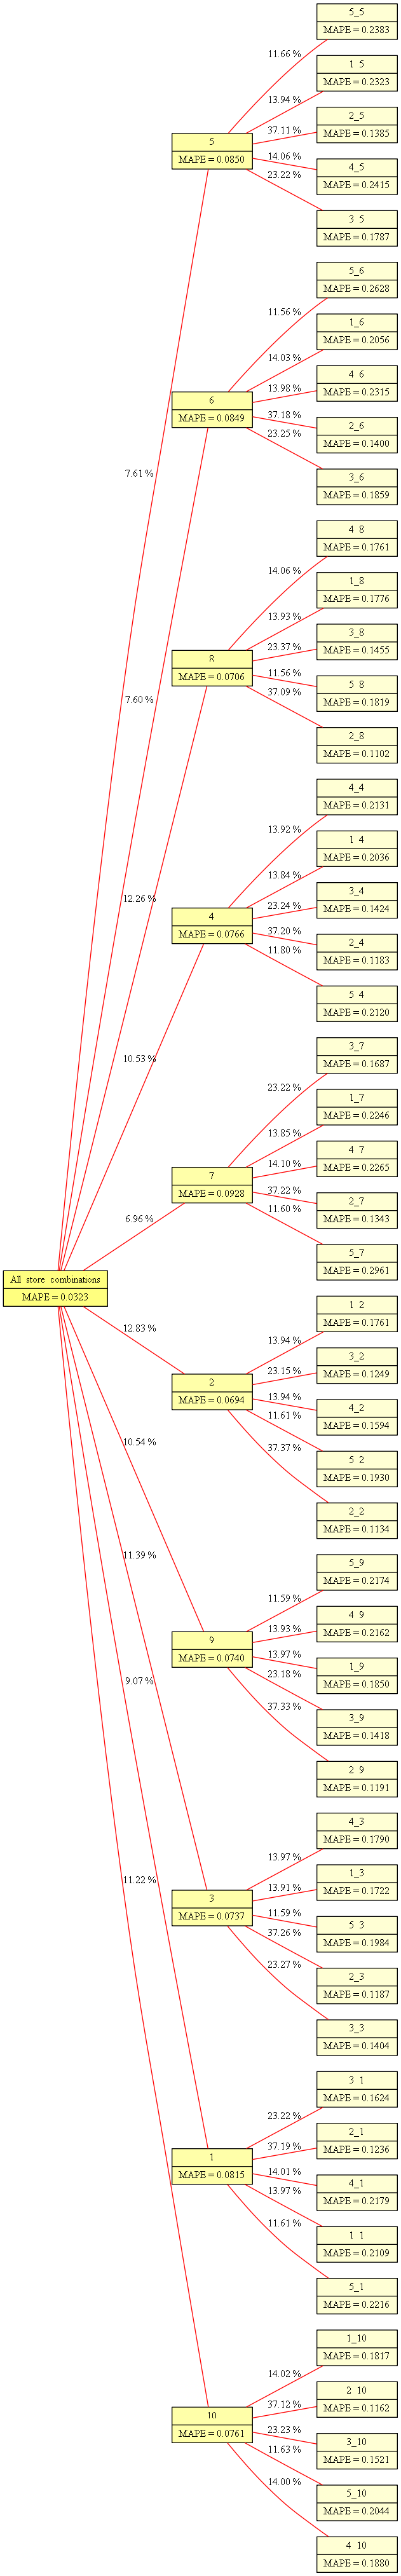

INFO:pyaf.std:END_HIERARCHICAL_PLOTTING_TIME_IN_SECONDS 0.7504820823669434


In [619]:
lEngine.mSignalHierarchy.plot()

In [621]:
lInfo = lEngine.to_json()
lInfo.keys()

dict_keys(['Structure', 'Models'])

In [638]:
lInfo['Structure']

{0: {'1_1': set(),
  '1_2': set(),
  '1_3': set(),
  '1_4': set(),
  '1_5': set(),
  '1_6': set(),
  '1_7': set(),
  '1_8': set(),
  '1_9': set(),
  '1_10': set(),
  '2_1': set(),
  '2_2': set(),
  '2_3': set(),
  '2_4': set(),
  '2_5': set(),
  '2_6': set(),
  '2_7': set(),
  '2_8': set(),
  '2_9': set(),
  '2_10': set(),
  '3_1': set(),
  '3_2': set(),
  '3_3': set(),
  '3_4': set(),
  '3_5': set(),
  '3_6': set(),
  '3_7': set(),
  '3_8': set(),
  '3_9': set(),
  '3_10': set(),
  '4_1': set(),
  '4_2': set(),
  '4_3': set(),
  '4_4': set(),
  '4_5': set(),
  '4_6': set(),
  '4_7': set(),
  '4_8': set(),
  '4_9': set(),
  '4_10': set(),
  '5_1': set(),
  '5_2': set(),
  '5_3': set(),
  '5_4': set(),
  '5_5': set(),
  '5_6': set(),
  '5_7': set(),
  '5_8': set(),
  '5_9': set(),
  '5_10': set()},
 1: {'1': {'1_1', '2_1', '3_1', '4_1', '5_1'},
  '2': {'1_2', '2_2', '3_2', '4_2', '5_2'},
  '3': {'1_3', '2_3', '3_3', '4_3', '5_3'},
  '4': {'1_4', '2_4', '3_4', '4_4', '5_4'},
  '5': {'1_5

In [639]:
lInfo['Models']

{'1_1': {'Dataset': {'Time': {'TimeVariable': 'date',
    'TimeMinMax': ['2013-01-01 00:00:00', '2017-12-31 00:00:00'],
    'Horizon': 1},
   'Signal': '1_1',
   'Training_Signal_Length': 1826},
  'Model': {'Best_Decomposition': '_1_1_ConstantTrend_residue_zeroCycle_residue_AR(64)',
   'Signal_Transoformation': 'NoTransf',
   'Trend': 'ConstantTrend',
   'Cycle': 'NoCycle',
   'AR_Model': 'AR'},
  'Model_Performance': {'MAPE': '0.2109',
   'MASE': '0.6475',
   'MAE': '4.075399694370768',
   'RMSE': '5.100012328560195',
   'COMPLEXITY': '64'}},
 '1_10': {'Dataset': {'Time': {'TimeVariable': 'date',
    'TimeMinMax': ['2013-01-01 00:00:00', '2017-12-31 00:00:00'],
    'Horizon': 1},
   'Signal': '1_10',
   'Training_Signal_Length': 1826},
  'Model': {'Best_Decomposition': '_1_10_ConstantTrend_residue_zeroCycle_residue_AR(64)',
   'Signal_Transoformation': 'NoTransf',
   'Trend': 'ConstantTrend',
   'Cycle': 'NoCycle',
   'AR_Model': 'AR'},
  'Model_Performance': {'MAPE': '0.1817',
   'MA

In [635]:
perfs = [];
for model in sorted(lInfo['Models'].keys()):
    lPerf = lInfo['Models'][model]['Model_Performance']
    perfs.append([model , lPerf['RMSE'] , lPerf['MAPE']])
df_perf = pd.DataFrame(perfs , columns=['Model' , 'RMSE' , 'MAPE']);
df_perf = df_perf.sort_values(by = ['MAPE'])
print(df_perf)

                     Model                RMSE    MAPE
60  All_store_combinations   76.33626929236198  0.0323
12                       2  19.465894198668448  0.0694
58                       8   19.26469885497681  0.0706
23                       3   18.55456590959121  0.0737
59                       9  16.965658377948998   0.074
1                       10    18.0174150217357  0.0761
34                       4  17.952074006348212  0.0766
0                        1  15.285727352770635  0.0815
56                       6  14.217017071573277  0.0849
45                       5  14.257710498512727   0.085
57                       7  13.316051919367043  0.0928
21                     2_8  10.988169873446905  0.1102
15                     2_2  11.569257527523026  0.1134
14                    2_10  10.153974859885034  0.1162
17                     2_4   9.924042101687862  0.1183
16                     2_3  10.857451799002211  0.1187
22                     2_9  10.022363617865867  0.1191
13        

In [643]:
engine_1_1=lEngine.mSignalHierarchy.mModels[0]['1_1']

In [644]:
engine_1_1.getModelInfo()

INFO:pyaf.std:TIME_DETAIL TimeVariable='date' TimeMin=2013-01-01T00:00:00.000000 TimeMax=2016-12-30T00:00:00.000000 TimeDelta=<DateOffset: days=1> Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='1_1' Min=4 Max=50  Mean=19.971522453450163 StdDev=6.7391761080508115
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_1_1' Min=4 Max=50  Mean=19.971522453450163 StdDev=6.7391761080508115
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_1_1_ConstantTrend_residue_zeroCycle_residue_AR(64)' [ConstantTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_1_1_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_1_1_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_1_1_ConstantTrend_residue_zeroCycle_residue_AR(64)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.2201 MAPE_Forecast=0.2109 MAPE_Test=0.0568
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.1979 SMAPE_Forecast=0.1935 SMAPE_Test=0.0585
INFO:pyaf.std:MODEL_MASE MASE_Fit=0

INFO:pyaf.std:START_PLOTTING
INFO:pyaf.std:END_PLOTTING_TIME_IN_SECONDS 2.0680439472198486


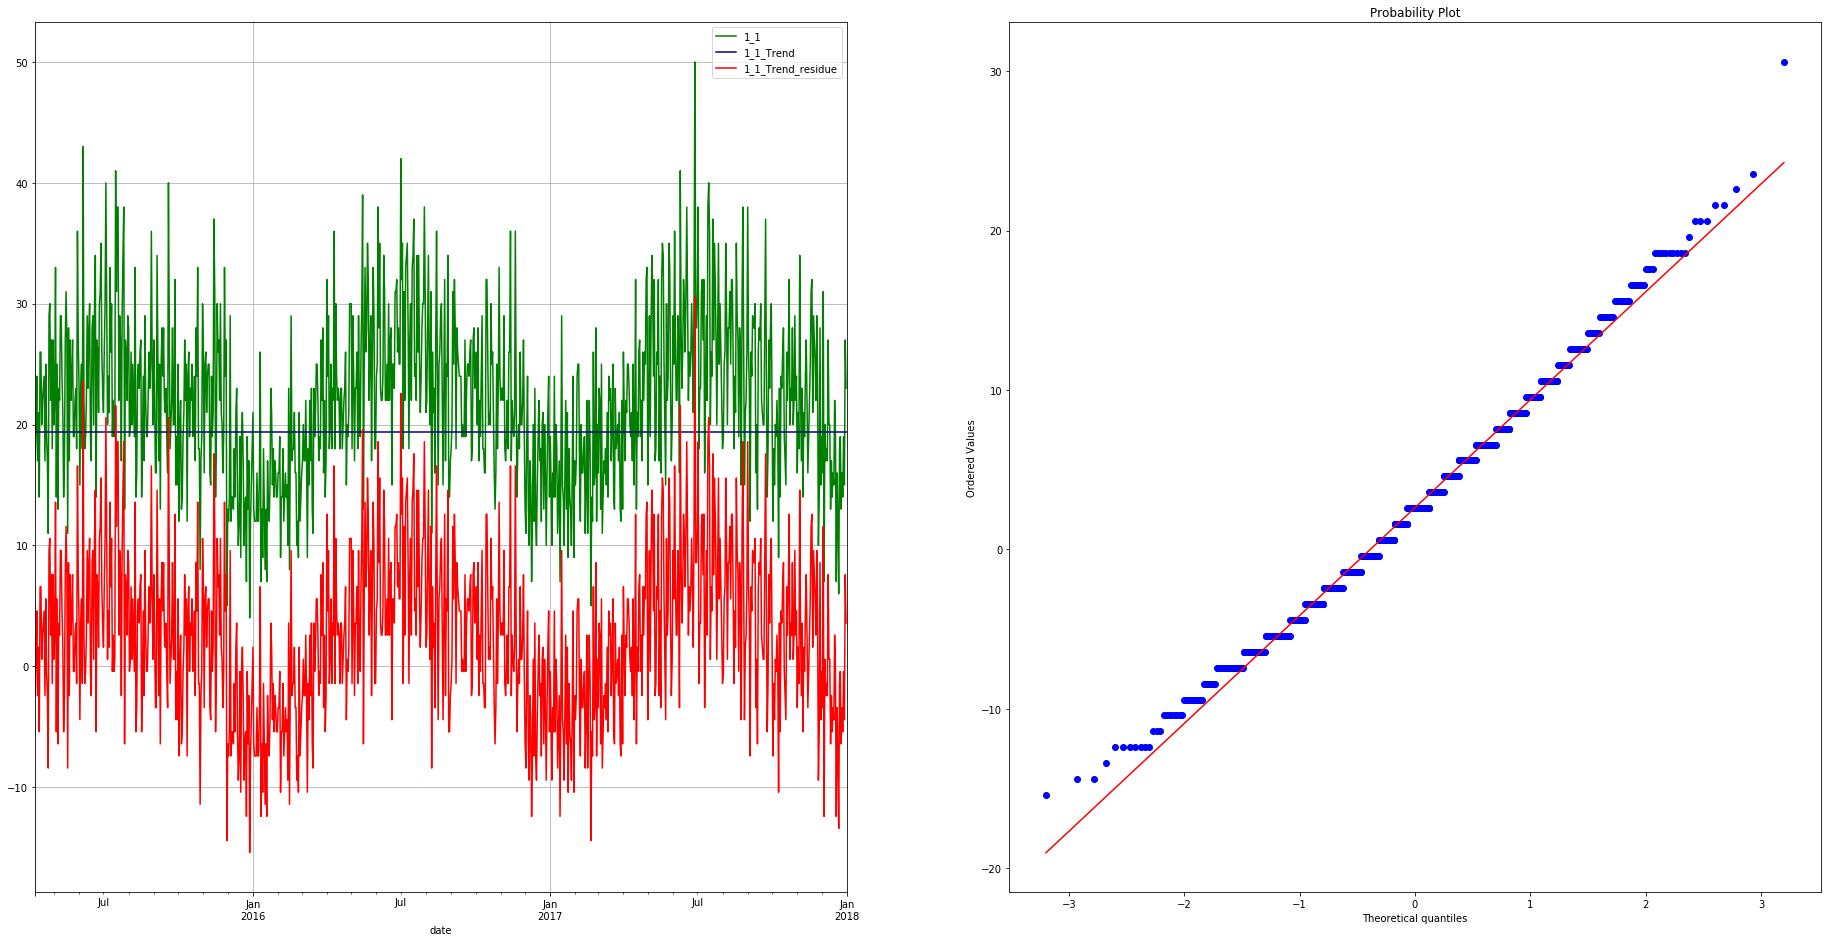

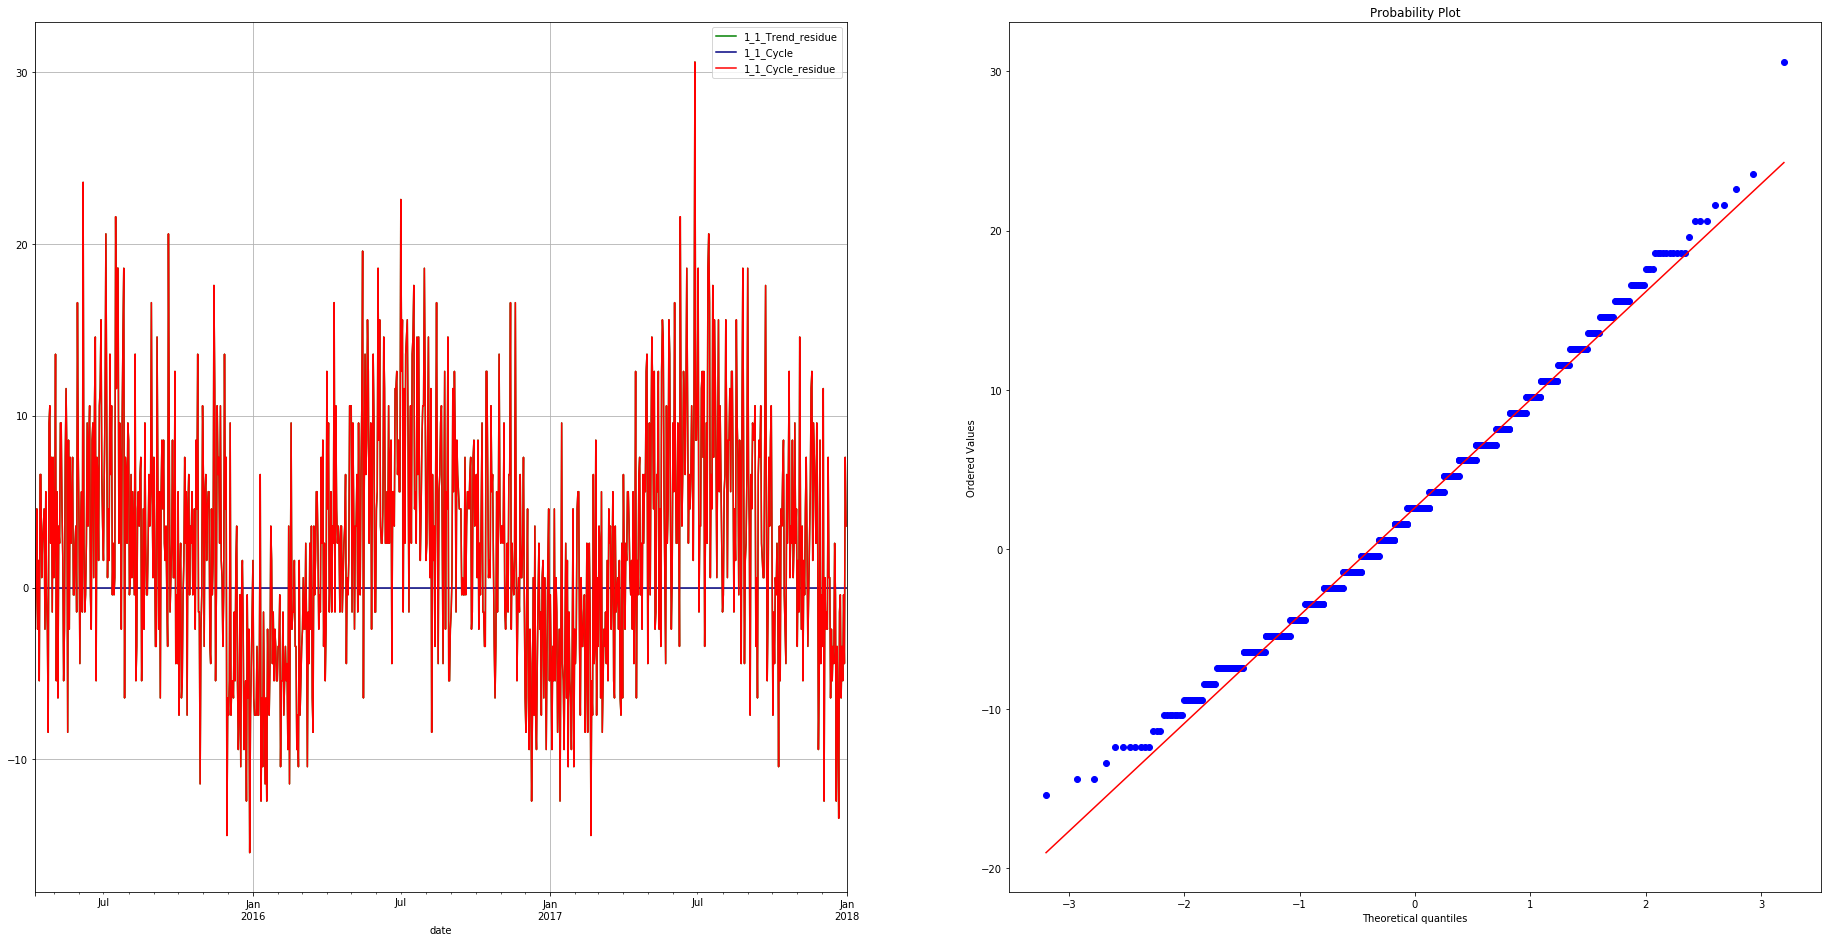

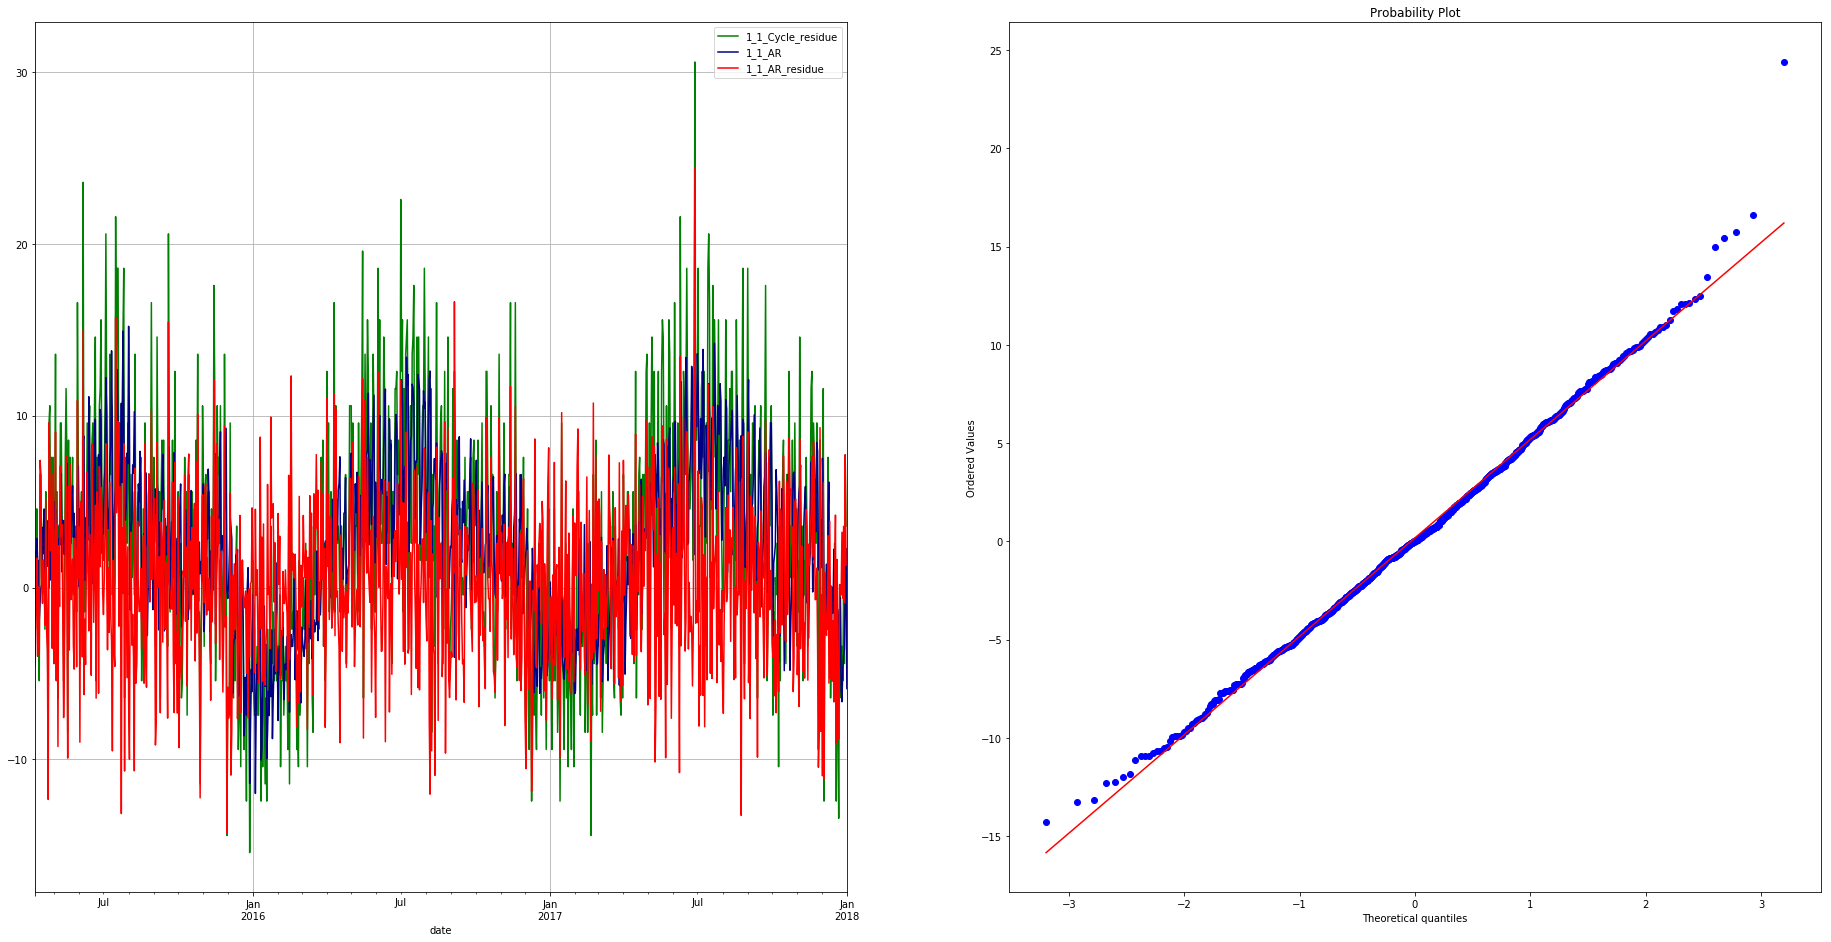

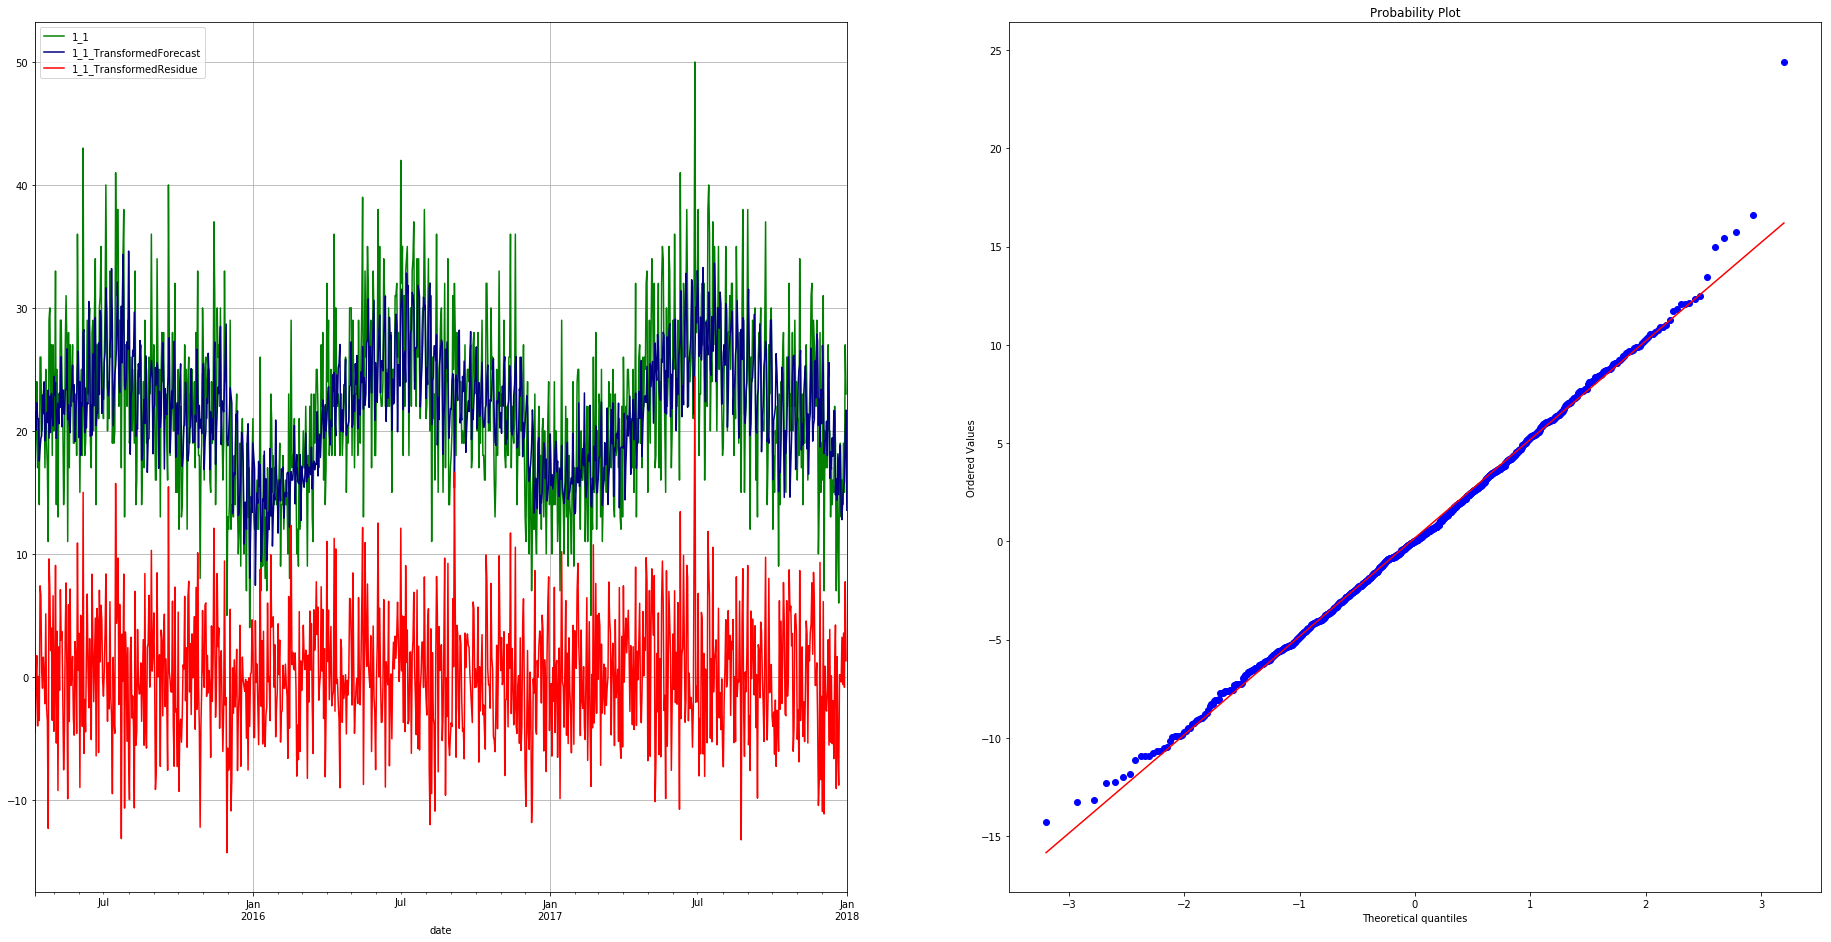

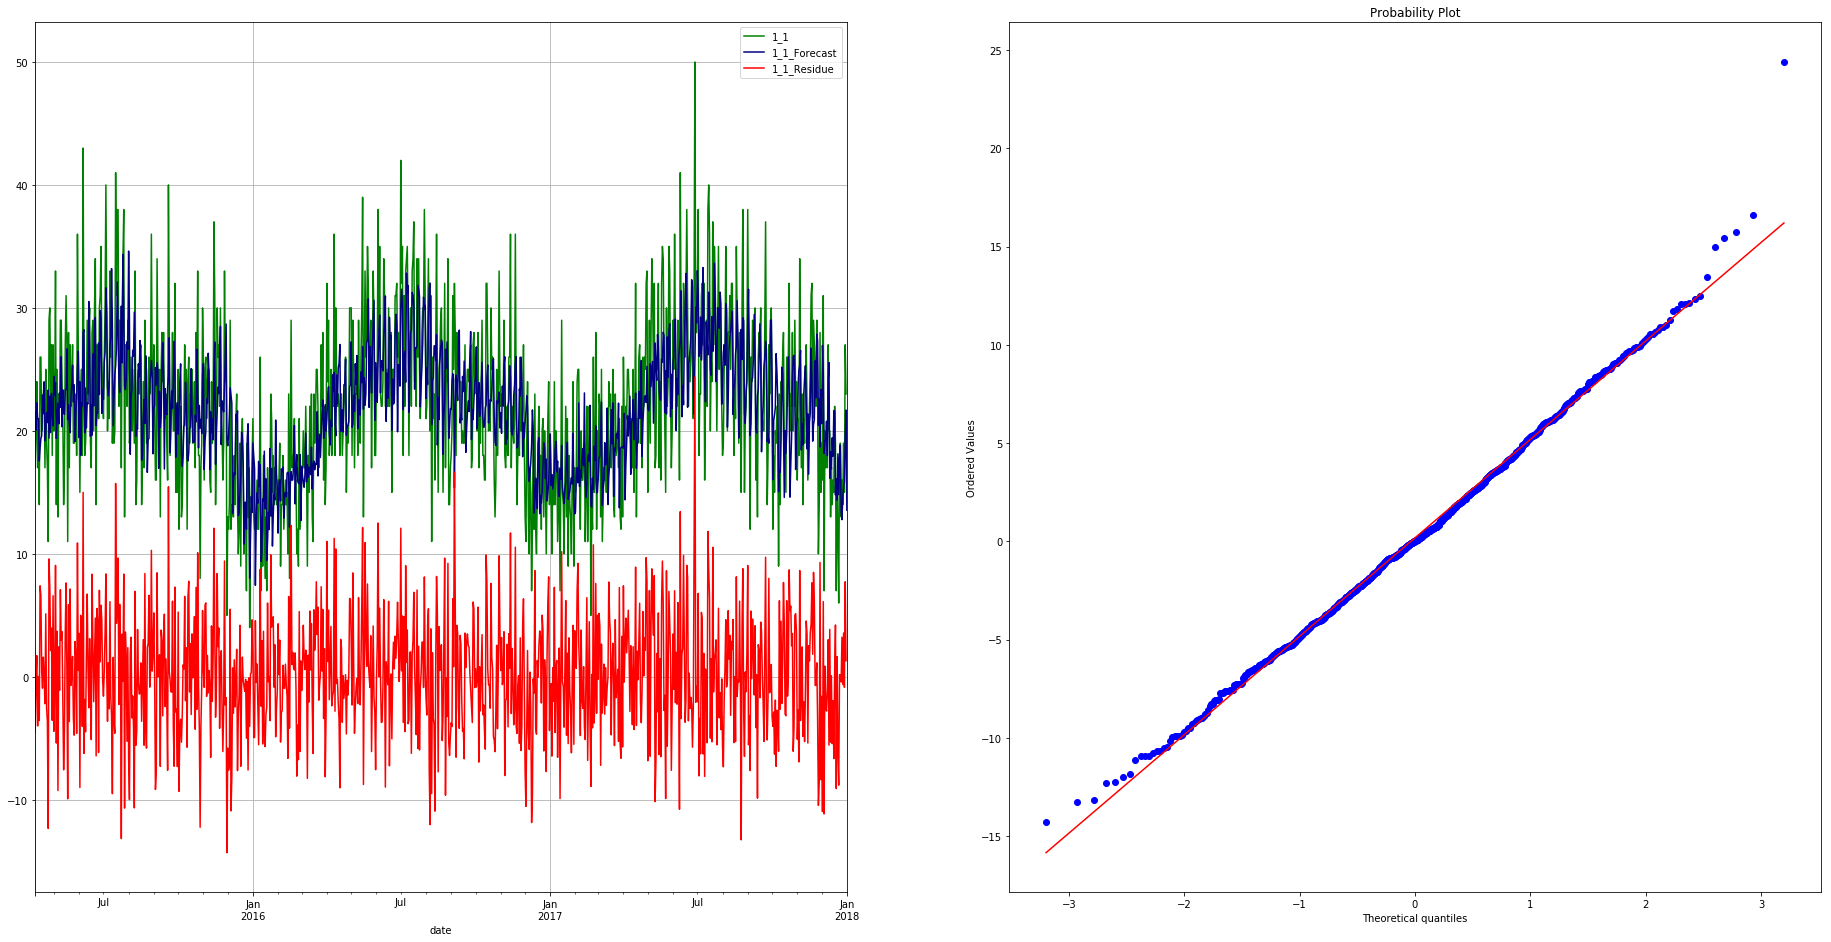

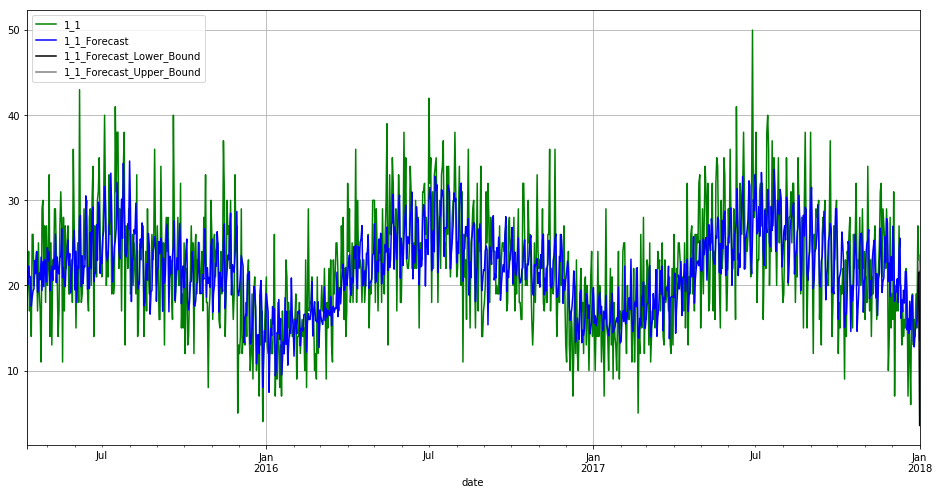

In [645]:
engine_1_1.standardPlots()

#dont use time series object for pyaf
ts1 = ts1['sales']
ts1.head()